In [1]:
%reload_ext autoreload
%autoreload 2
# %load_ext wurlitzer

import sys
sys.path.append("../")

import numpy as np
import time
from utils import model
from inference import log_marginal_likelihood
from inference import logmarglik
from inference import zstates as zs
from inference import zstates_old_method as zs_old
from utils import hyperparameters
from iotools import snp_annotator

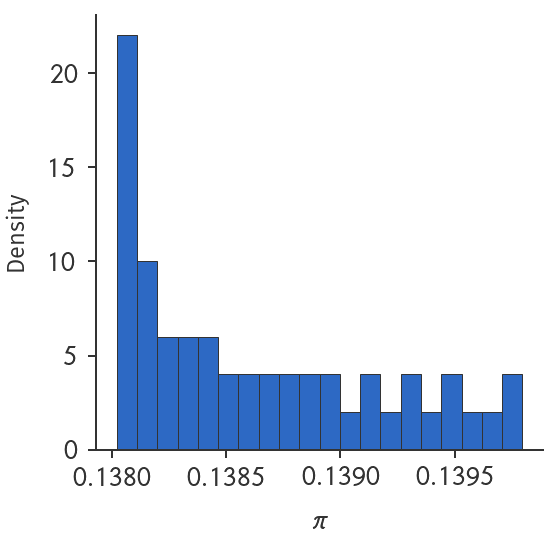

Creating phenotype with sigma 0.2, heritability 0.81284, sigma_tau 0.43262
Using 14 causal SNPs


In [2]:
nsample = 300
nsnps = 100
pi = 0.05
mu = 0.0
sigmabg = 0.0
sigma = 0.2

# No feature
features = np.ones((nsnps, 1))

# Add a random feature
myfeat = np.zeros((nsnps, 1))
myfeat[np.random.permutation(np.arange(nsnps))[:int(nsnps / 4)]] = 1
#features = np.concatenate((features, myfeat), axis=1)

# Add distance feature
dist = np.linspace(-40000, 40000, nsnps)
distfeat = snp_annotator.myTcurve(dist)
distfeat = 1 / distfeat

# Create gamma
gamma = np.zeros(features.shape[1])
gamma[0] = - np.log((1 / pi) - 1)
enrich = 2
gval = np.log(enrich) - np.log(1 + (1 - enrich) * np.exp(gamma[0]))
gamma[1:] = np.repeat(gval, features.shape[1] - 1)

x, y, csnps, v = model.simulate(nsample, nsnps, 
                                features, 1 / distfeat, gamma,
                                mu = mu,
                                sigma = sigma,
                                sigmabg = sigmabg,)

In [3]:
tau = 1 / (1 - np.sum(np.square(v[csnps])))
params = np.append(gamma, [mu, sigma, sigmabg, tau])
scaledparams = hyperparameters.scale(params)

In [4]:
cmax = 1
zstates_new = zs.create(scaledparams, x, y, features, distfeat, cmax, nsnps, 0.98)
# zstates_old = zs_old.create(scaledparams, x, y, features, cmax, nvar, 0.98)
# zstates_new = zstates_old

In [5]:
zstates = zstates_new
scaledparams = hyperparameters.scale(params)
success, m, der = logmarglik.func_grad(scaledparams, x, y, features, distfeat, zstates)
nfeat = features.shape[1]

# Derivatives of gamma
for i in range(0, nfeat):
    delta = 1e-8
    newparams = hyperparameters.scale(params)
    newparams[i] += delta
    newm = logmarglik.func(newparams, x, y, features, distfeat, zstates)
    gamma_grad = (newm - m) / delta
    print ("Derivative of gamma {:d} by brute force is {:f}".format(i, gamma_grad))
    print ("Derivative of gamma {:d} from equation is {:f}".format(i, der[i]))

# Derivative of mu
delta = 1e-8
newparams = hyperparameters.scale(params)
newparams[nfeat + 0] += delta
newm = logmarglik.func(newparams, x, y, features, distfeat, zstates)
mu_grad = (newm - m) / delta
print ("Derivative of mu by brute force is {:f}".format(mu_grad))
print ("Derivative of mu from equation is {:f}".format(der[nfeat + 0]))

# Derivative of sigma
delta = 0.01
newparams = hyperparameters.scale(params)
newparams[nfeat + 1] += delta
newm = logmarglik.func(newparams, x, y, features, distfeat, zstates)
sigma_grad = (newm - m) / delta
print ("Derivative of sigma by brute force is {:f}".format(sigma_grad))
print ("Derivative of sigma from equation is {:f}".format(der[nfeat + 1]))

# Derivative of sigbg
delta = 1e-7
newparams = hyperparameters.scale(params)
newparams[nfeat + 2] += delta
newm = logmarglik.func(newparams, x, y, features, distfeat, zstates)
sigbg_grad = (newm - m) / delta
print ("Derivative of sigbg by brute force is {:f}".format(sigbg_grad))
print ("Derivative of sigbg from equation is {:f}".format(der[nfeat + 2]))

# Derivative of tau
delta = 1e-8
newparams = hyperparameters.scale(params)
newparams[nfeat + 3] += delta
newm = logmarglik.func(newparams, x, y, features, distfeat, zstates)
tau_grad = (newm - m) / delta
print ("Derivative of tau by brute force is {:f}".format(tau_grad))
print ("Derivative of tau from equation is {:f}".format(der[nfeat + 3]))

Derivative of gamma 0 by brute force is 0.692137
Derivative of gamma 0 from equation is 0.692146
Derivative of mu by brute force is -0.122520
Derivative of mu from equation is -0.122507
Derivative of sigma by brute force is -4.957970
Derivative of sigma from equation is -5.016194
Derivative of sigbg by brute force is 0.000000
Derivative of sigbg from equation is -0.000000
Derivative of tau by brute force is -1278.553043
Derivative of tau from equation is -1278.553005
